Connecting to Augur

In [2]:
import pandas as pd
import json
import sqlalchemy as salc
import psycopg2

with open("../config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(
                              config['user'],
                              config['password'],
                              config['host'],
                              config['port'],
                              config['database']
                            )

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Activity Metrics
- SQL query for github activity metrics
- Focused on the increment in activity (star/fork/watch/committer/commit/issue) over time to prevent from old repo having lots of accumulated activity.
    -  Assigned different weights for #increase_in_stars, #increase_in_forks, #increase_in_watch, #increase_in_committer, #increase_in_commit, #increase_in_issue, #increase_in_pr, #increase_in_pr_open, #increase_in_pr_close, #increase_in_pr_merge, then sum them together

In [3]:
dframe = pd.DataFrame()

repo_query = salc.sql.text(f"""
SELECT x.repo_id,
       x.rg_name,
       x.repo_name,
       last_updated,
       DATE(last_updated),
       to_char(last_updated, 'DAY'),
       EXTRACT(year FROM last_updated) AS "Year",
       EXTRACT(month FROM last_updated) AS "month",
       extract(hour from last_updated) AS "hour",
       x.increase_committer,
       x.increase_pr_open,
       x.increase_commit,
       (x.increase_committer + x.increase_pr_open + x.increase_pr_close + x.increase_pr_merge + x.increase_issue + x.increase_pr + x.increase_star + x.increase_fork)*10 AS total
            FROM(
        SELECT 
            rg.repo_group_id,
            rg.rg_name,
            r.repo_id,
            r.repo_name,
            /*ri.license,*/
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.stars_count - lag(ri.stars_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 0.01
            END
                AS increase_star,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.fork_count - lag(ri.fork_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 0.25
            END
                AS increase_fork,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.watchers_count - lag(ri.watchers_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 0.1
            END
                AS increase_watch,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.committers_count - lag(ri.committers_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) *1.5
            END
                AS increase_committer,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.commit_count - lag(ri.commit_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.2
            END
                AS increase_commit,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.issues_count - lag(ri.issues_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.3
            END
                AS increase_issue,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.pull_request_count - lag(ri.pull_request_count) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.6
            END
                AS increase_pr,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.pull_requests_open - lag(ri.pull_requests_open) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.6
            END
                AS increase_pr_open,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.pull_requests_closed - lag(ri.pull_requests_closed) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 1.8
            END
                AS increase_pr_close,
            CASE
                WHEN r.repo_id - lag(r.repo_id) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) = 0 THEN 
                (ri.pull_requests_merged - lag(ri.pull_requests_merged) over (order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated)) * 2    
            END
                AS increase_pr_merge,
            ri.last_updated,
            CASE
                WHEN EXTRACT(YEAR FROM ri.last_updated) < 2022 THEN 'far away'
                WHEN EXTRACT(YEAR FROM ri.last_updated) >= 2022 THEN 'recent'
            END
                AS segment,
            EXTRACT(year FROM last_updated) AS "Year",
            EXTRACT(month FROM last_updated) AS "month" 
        FROM REPO r
            LEFT JOIN repo_groups rg
            ON rg.repo_group_id = r.repo_group_id
            LEFT join repo_info ri 
            on r.repo_id = ri.repo_id 
        /*where rg.rg_name = 'agroal'*/
        order by rg.repo_group_id ASC, r.repo_id ASC, ri.last_updated) AS x
""")

dframe = pd.read_sql(repo_query, con=engine)
dframe.head()

repo_id             rg_name              repo_name        last_updated  \
0    24441  Default Repo Group  operate-first-twitter 2021-10-12 09:19:15   
1    24441  Default Repo Group  operate-first-twitter 2021-10-12 09:19:15   
2    24441  Default Repo Group  operate-first-twitter 2021-10-26 18:15:41   
3    24441  Default Repo Group  operate-first-twitter 2021-10-26 18:15:41   
4    24441  Default Repo Group  operate-first-twitter 2021-10-26 18:15:41   

         date    to_char    Year  month  hour  increase_committer  \
0  2021-10-12  TUESDAY    2021.0   10.0   9.0                 NaN   
1  2021-10-12  TUESDAY    2021.0   10.0   9.0                 0.0   
2  2021-10-26  TUESDAY    2021.0   10.0  18.0               -15.0   
3  2021-10-26  TUESDAY    2021.0   10.0  18.0                 0.0   
4  2021-10-26  TUESDAY    2021.0   10.0  18.0                16.5   

   increase_pr_open  increase_commit  total  
0               NaN              NaN    NaN  
1               0.0              NaN    0.0  
2              -1.6              NaN -146.0  
3               0.0              NaN    0.0  
4               0.0              NaN  165.0

In [4]:
# Fill all NA value into zero
dframe = dframe.fillna(0)
# calculating activeness percentage based on org and repo_name
df2 = dframe.groupby(['rg_name', 'repo_name']).agg({'total': 'sum'})
df3 = df2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
df4 = df3['total'].to_frame().reset_index()
df4 = df4[df4['total'] != 0.0]
df4.head()

# extract column 'month' and 'percentage', copy it as another dataframe
# dft = dtest[['month', 'percentage']].copy()
# dft = dframe['percentage'].copy()

rg_name                       repo_name     total
0  3scale                          3scale -0.547708
1  3scale               3scale-Operations  0.542299
2  3scale  3scale-amp-openshift-templates  0.498347
5  3scale                3scale-go-client  0.000676
6  3scale            3scale-istio-adapter -0.388129

### Bar chart

In [20]:
import plotly.express as px

fig = px.bar(df4, x="rg_name", y="total", color="repo_name", text="repo_name")
fig.show()

### Pie chart

In [27]:
drepo = df4[df4['rg_name'] == 'kubernetes']

import plotly.express as px
fig_pie = px.pie(data_frame=drepo, names='repo_name', values='total')
fig_pie.show()

### Plot for org Density by Activities

In [5]:
dframe = dframe.fillna(0)
# calculating activeness percentage based on org and repo_name
df2 = dframe.groupby(['rg_name', 'repo_name']).agg({'total': 'sum'})
ho = df2['total'].to_frame().reset_index()


hoo = ho.groupby(['rg_name']).agg({'total': 'sum'})
drank = hoo.reset_index()
drank.sort_values(by = 'total', ascending=False).reset_index()
drank.head()

rg_name    total
0             3scale  14788.9
1        3scale-labs   -160.0
2  Anaconda-Platform    942.4
3          AppFormer    -30.0
4             CentOS  11764.2

In [6]:
import plotly.express as px

fig = px.bar(drank, x="total", y="rg_name", orientation='h')
fig.show()

### Comments

In [2]:
# Activity
dframe_msg = pd.DataFrame()

message_query = salc.sql.text(f"""
    SELECT x.repo_id,
            x.repo_name,
            x.timeyear,
            x.timemonth,
            x.timedate,
            COUNT(*) AS num_of_comment
    FROM(
        SELECT m.repo_id, 
                r.repo_name,
                EXTRACT (year FROM msg_timestamp) AS timeyear,
                EXTRACT (month FROM msg_timestamp) AS timemonth,
                EXTRACT (day FROM msg_timestamp) AS timedate
                FROM message m 
            left join repo r 
            on m.repo_id = r.repo_id 
            where m.repo_id is not null
            limit 1000
        ) AS x
    GROUP BY x.repo_id, x.repo_name, x.timeyear, x.timemonth, x.timedate
    ORDER BY x.repo_id, x.timeyear, x.timemonth, x.timedate
""")

dframe_msg = pd.read_sql(message_query, con=engine)
dframe_msg.head()

repo_id           repo_name  timeyear  timemonth  timedate  num_of_comment
0    24442           blueprint    2021.0        3.0      15.0               1
1    27445             support    2021.0       10.0       1.0               1
2    27447             curator    2021.0        5.0      12.0               1
3    27447             curator    2021.0       10.0       6.0               1
4    27457  community-handbook    2021.0        7.0       8.0               1

In [3]:
dframe_msg = dframe_msg.fillna(0)
print(len(dframe_msg))

238


In [5]:
import plotly.express as px

fig = px.bar(dframe_msg, x = 'timeyear', y = 'num_of_comment', color='repo_name',
                labels={'num_of_comment': 'Number Of Comments'},
                height = 400)
fig.show()

- Calculate number of comments for a repo by identifying unique contributor and within what timeframe

In [9]:
dframe_unq_msg_cntrb = pd.DataFrame()

unq_msg_cntrb_query = salc.sql.text(f"""
	SELECT x.repo_id,
			x.repo_name,
			x.datetime,
			COUNT(x.msg_text) AS num_of_comments,
			COUNT(distinct x.cntrb_id) AS num_of_unique_msg_cntrb
		FROM(
			SELECT m.repo_id,
					r.repo_name,
					m.cntrb_id,
					m.msg_text,
					TO_CHAR(msg_timestamp  :: DATE, 'yyyy-mm-dd') AS datetime
			FROM message m
			LEFT JOIN repo r
				ON m.repo_id = r.repo_id
			WHERE m.repo_id is not null
			ORDER BY m.repo_id, datetime
			) AS x
		GROUP BY x.datetime, x.repo_id, x.repo_name
	ORDER BY x.repo_id, x.datetime
""")

dframe_unq_msg_cntrb = pd.read_sql(unq_msg_cntrb_query, con=engine)
dframe_unq_msg_cntrb.head()

repo_id              repo_name    datetime  num_of_comments  \
0    24441  operate-first-twitter  2021-04-26               18   
1    24441  operate-first-twitter  2021-04-28               11   
2    24441  operate-first-twitter  2021-04-30               24   
3    24441  operate-first-twitter  2021-05-03                7   
4    24441  operate-first-twitter  2021-05-06                8   

   num_of_unique_msg_cntrb  
0                        4  
1                        3  
2                        4  
3                        3  
4                        5

In [13]:
dtest = dframe_unq_msg_cntrb[dframe_unq_msg_cntrb['repo_id'] == 24441]
dtest.head()

repo_id              repo_name    datetime  num_of_comments  \
0    24441  operate-first-twitter  2021-04-26               18   
1    24441  operate-first-twitter  2021-04-28               11   
2    24441  operate-first-twitter  2021-04-30               24   
3    24441  operate-first-twitter  2021-05-03                7   
4    24441  operate-first-twitter  2021-05-06                8   

   num_of_unique_msg_cntrb  
0                        4  
1                        3  
2                        4  
3                        3  
4                        5

Number of Comments V.S. Number of Unique Comment Contributors by day

In [12]:
import plotly.graph_objects as go

benchmark_value = dtest['num_of_comments'].mean()


fig = go.Figure()
fig.add_trace(go.Bar(
    x=dtest['datetime'],
    y=dtest['num_of_comments'],
    name='Number Of Comments',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=dtest['datetime'],
    y=dtest['num_of_unique_msg_cntrb'],
    name='Number Of Unique Contributors',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.add_hline(y=benchmark_value, annotation_text=f"{round(benchmark_value, 2)}: Avg for # of comments", line_dash='dot', annotation_font_size=20)
fig.add_hline(y=dtest['num_of_unique_msg_cntrb'].mean(), annotation_text=f"{round(dtest['num_of_unique_msg_cntrb'].mean(),2)}: Avg for # of unique comment contributors")
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Number of Comments V.S. Number of Unique Comment Contributors by day - operate-first-twitter repo')
fig.show()

In [8]:
dframe_unq_msg_cntrb = pd.DataFrame()

unq_msg_cntrb_query = salc.sql.text(f"""
	SELECT x.repo_id,
			x.repo_name,
			x.yearmonth,
			COUNT(x.msg_text) AS num_of_comments,
			COUNT(distinct x.cntrb_id) AS num_of_unique_msg_cntrb
		FROM(
			SELECT m.repo_id,
					r.repo_name,
					m.cntrb_id,
					m.msg_text,
					CAST(EXTRACT(YEAR FROM msg_timestamp) AS text) || '-' || CAST(EXTRACT(MONTH FROM msg_timestamp) AS text) AS yearmonth
			FROM message m
			LEFT JOIN repo r
				ON m.repo_id = r.repo_id
			WHERE m.repo_id is not null
			ORDER BY m.repo_id, yearmonth
			) AS x
		GROUP BY x.repo_id, x.repo_name, x.yearmonth
	ORDER BY x.repo_id, x.yearmonth
""")

dframe_unq_msg_cntrb = pd.read_sql(unq_msg_cntrb_query, con=engine)
dframe_unq_msg_cntrb.head()

repo_id              repo_name yearmonth  num_of_comments  \
0    24441  operate-first-twitter   2021-10                5   
1    24441  operate-first-twitter   2021-11                9   
2    24441  operate-first-twitter   2021-12               12   
3    24441  operate-first-twitter    2021-4               53   
4    24441  operate-first-twitter    2021-5               22   

   num_of_unique_msg_cntrb  
0                        3  
1                        2  
2                        3  
3                        5  
4                        6

In [182]:
dhey = dframe_unq_msg_cntrb[dframe_unq_msg_cntrb['repo_name'] == 'kubernetes']
dhey.head()

repo_id   repo_name yearmonth  num_of_comments  num_of_unique_msg_cntrb
23436    27835  kubernetes   2014-10             2658                      100
23437    27835  kubernetes   2014-11             2620                      120
23438    27835  kubernetes   2014-12             2466                      137
23439    27835  kubernetes    2014-6              617                       40
23440    27835  kubernetes    2014-7             1908                       77

Number of Comments V.S. Number of Unique Comment Contributors by month -- Kubernetes repo

In [185]:
benchmark_value = dhey['num_of_comments'].mean()
dhey['benchmark_score'] = dhey['num_of_comments'] - benchmark_value
benchmark_value
dhey.head()

/tmp/ipykernel_47856/3730407234.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



repo_id   repo_name yearmonth  num_of_comments  \
23436    27835  kubernetes   2014-10             2658   
23437    27835  kubernetes   2014-11             2620   
23438    27835  kubernetes   2014-12             2466   
23439    27835  kubernetes    2014-6              617   
23440    27835  kubernetes    2014-7             1908   

       num_of_unique_msg_cntrb  benchmark_score  
23436                      100       1977.09009  
23437                      120       1939.09009  
23438                      137       1785.09009  
23439                       40        -63.90991  
23440                       77       1227.09009

In [199]:
import plotly.graph_objects as go

benchmark_value = dhey['num_of_comments'].mean()


fig = go.Figure()
fig.add_trace(go.Bar(
    x=dhey['yearmonth'],
    y=dhey['num_of_comments'],
    name='Number Of Comments',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=dhey['yearmonth'],
    y=dhey['num_of_unique_msg_cntrb'],
    name='Number Of Unique Contributors',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.add_hline(y=benchmark_value, annotation_text=f" {round(benchmark_value,2)}: Avg for # of comments", line_dash='dot', annotation_font_size=20)
fig.add_hline(y=dhey['num_of_unique_msg_cntrb'].mean(), annotation_text= f" {round(dhey['num_of_unique_msg_cntrb'].mean(),2)} : Avg for # of unique comment contributors")
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Number of Comments V.S. Number of Unique Comment Contributors by month - Kubernetes repo')
fig.show()

# Community
### Contributors
Defined as committers and authors

In [31]:
df_pr_committers = pd.DataFrame()
df_pr_authors = pd.DataFrame()

committer_query = salc.sql.text(f"""
    SELECT x.repo_id,
            x.repo_name,
            x.cmt_committer_date,
            COUNT(x.cmt_id) AS num_of_commit,
            COUNT(DISTINCT x.cmt_committer_raw_email) AS num_of_unique_commit
        FROM(
            SELECT c.repo_id,
                    r.repo_name,
                    c.cmt_id,
                    c.cmt_committer_raw_email,
                    c.cmt_committer_date 
            FROM commits c 
            LEFT JOIN repo r
                ON c.repo_id = r.repo_id
            WHERE c.repo_id is not null
            ORDER BY c.repo_id, c.cmt_committer_date
            ) as x
        GROUP BY x.cmt_committer_date, x.repo_id, x.repo_name
    ORDER BY x.repo_id, x.cmt_committer_date
""")


author_query = salc.sql.text(f"""
    SELECT x.repo_id,
            x.repo_name,
            x.cmt_author_date,
            COUNT(x.cmt_id) AS num_of_author,
            COUNT(DISTINCT x.cmt_author_raw_email) AS num_of_unique_author
        FROM(
            SELECT c.repo_id,
                    r.repo_name,
                    c.cmt_id,
                    c.cmt_author_raw_email,
                    c.cmt_author_date 
            FROM commits c 
            LEFT JOIN repo r
                ON c.repo_id = r.repo_id
            WHERE c.repo_id is not null
            ORDER BY c.repo_id, c.cmt_author_date
            ) as x
        GROUP BY x.cmt_author_date, x.repo_id, x.repo_name
    ORDER BY x.repo_id, x.cmt_author_date
    LIMIT 10
""")

In [33]:
df_pr_committers = pd.read_sql(committer_query, con=engine)
df_pr_committers.head()

repo_id              repo_name cmt_committer_date  num_of_commit  \
0    24441  operate-first-twitter         2021-04-25              3   
1    24441  operate-first-twitter         2021-04-26              8   
2    24441  operate-first-twitter         2021-04-28              5   
3    24441  operate-first-twitter         2021-04-30              2   
4    24441  operate-first-twitter         2021-05-03              1   

   num_of_unique_commit  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [32]:
df_pr_authors = pd.read_sql(author_query, con=engine)
df_pr_authors.head()

repo_id              repo_name cmt_author_date  num_of_author  \
0    24441  operate-first-twitter      2021-04-25              3   
1    24441  operate-first-twitter      2021-04-26              8   
2    24441  operate-first-twitter      2021-04-28              5   
3    24441  operate-first-twitter      2021-04-30              2   
4    24441  operate-first-twitter      2021-05-03              1   

   num_of_unique_author  
0                     2  
1                     3  
2                     2  
3                     1  
4                     1

Number of committers V.S. Number of unique committers over time -- Operate First Twitter repo

In [35]:
dcommit = df_pr_committers[df_pr_committers['repo_id'] == 24441]
dcommit.head()

repo_id              repo_name cmt_committer_date  num_of_commit  \
0    24441  operate-first-twitter         2021-04-25              3   
1    24441  operate-first-twitter         2021-04-26              8   
2    24441  operate-first-twitter         2021-04-28              5   
3    24441  operate-first-twitter         2021-04-30              2   
4    24441  operate-first-twitter         2021-05-03              1   

   num_of_unique_commit  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [37]:
import plotly.graph_objects as go

benchmark_value = dcommit['num_of_commit'].mean()


fig = go.Figure()
fig.add_trace(go.Bar(
    x=dcommit['cmt_committer_date'],
    y=dcommit['num_of_commit'],
    name='Number Of Committers',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=dcommit['cmt_committer_date'],
    y=dcommit['num_of_unique_commit'],
    name='Number Of Unique Committers',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.add_hline(y=benchmark_value, annotation_text=f"{round(benchmark_value, 2)}: Avg for # of Committers", line_dash='dot', annotation_font_size=20)
fig.add_hline(y=dcommit['num_of_unique_commit'].mean(), annotation_text=f"{round(dcommit['num_of_unique_commit'].mean(),2)}: Avg for # of unique Committers")
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Number of Committers V.S. Number of Unique Committers Contributors by day - operate-first-twitter repo')
fig.show()

Number of Authors V.S. Number of unique Authors over time -- Operate First Twitter repo

In [38]:
dauthor = df_pr_authors[df_pr_authors['repo_id'] == 24441]
dauthor.head()

repo_id              repo_name cmt_author_date  num_of_author  \
0    24441  operate-first-twitter      2021-04-25              3   
1    24441  operate-first-twitter      2021-04-26              8   
2    24441  operate-first-twitter      2021-04-28              5   
3    24441  operate-first-twitter      2021-04-30              2   
4    24441  operate-first-twitter      2021-05-03              1   

   num_of_unique_author  
0                     2  
1                     3  
2                     2  
3                     1  
4                     1

In [40]:
import plotly.graph_objects as go

benchmark_value = dauthor['num_of_author'].mean()


fig = go.Figure()
fig.add_trace(go.Bar(
    x=dauthor['cmt_author_date'],
    y=dauthor['num_of_author'],
    name='Number Of Authors',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=dauthor['cmt_author_date'],
    y=dauthor['num_of_unique_author'],
    name='Number Of Unique Authors',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.add_hline(y=benchmark_value, annotation_text=f"{round(benchmark_value, 2)}: Avg for # of Authors", line_dash='dot', annotation_font_size=20)
fig.add_hline(y=dauthor['num_of_unique_author'].mean(), annotation_text=f"{round(dauthor['num_of_unique_author'].mean(),2)}: Avg for # of unique Authors")
fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Number of Authors V.S. Number of Unique Authors Contributors by day - operate-first-twitter repo')
fig.show()

# Performance
## PR
SQL query for github performance metrics
- whether the PR is closed or open -> status
- time required to close an PR -> duration
- how many days has passed since the ticket is closed -> exp decay

In [41]:
dframe_pr = pd.DataFrame()

pr_query = salc.sql.text(f"""
/*
1. whether the PR is closed or open -> status
2. time required to close an PR -> duration
3. Only the data from 2021 (?)
4. how many days has passed since the ticket is closed -> exp decay
*/
SELECT repo_id,
		close_duration,
		exp_decay,
		count(pull_request_id) AS num,
		close_duration*exp_decay*count(pull_request_id) as total
		FROM(
			SELECT pull_request_id, repo_id,
				   pr_src_state,
				   (pr_closed_at - pr_created_at) AS pull_request_duration,
				   CASE 
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at <= INTERVAL '15 days' THEN 1
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at <= INTERVAL '30 days' THEN 0.66
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at <= INTERVAL '60 days' THEN 0.33
				   	WHEN pull_requests.pr_closed_at - pull_requests.pr_created_at > INTERVAL '90 days' THEN 0.1
				   	WHEN pull_requests.pr_closed_at IS NULL AND NOW() - pull_requests.pr_created_at < INTERVAL '45 days' THEN 0.5
				   	ELSE 0
				   END
				   AS close_duration,
				   NOW() - pull_requests.pr_closed_at AS "time_passed",
				   CASE 
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '30 days' THEN 1
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '60 days' THEN 0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '90 days' THEN 0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '120 days' THEN 0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '150 days' THEN 0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '180 days' THEN 0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '210 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '240 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '270 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '300 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '330 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - pull_requests.pr_closed_at < INTERVAL '360 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	ELSE 0
				   END
				   AS exp_decay,
				   pull_requests.pr_closed_at
			FROM pull_requests
			WHERE EXTRACT(YEAR FROM pull_requests.pr_closed_at) >= 2022
			ORDER BY repo_id 
		) AS x
	GROUP BY repo_id, close_duration, exp_decay
	order by repo_id

""")

dframe_pr = pd.read_sql(pr_query, con=engine)

dframe_pr.head()

repo_id  close_duration  exp_decay  num    total
0    25440            1.00    0.59049    3  1.77147
1    25458            1.00    0.59049    1  0.59049
2    25459            0.33    0.81000    1  0.26730
3    25459            0.66    0.90000    3  1.78200
4    25459            0.66    0.81000    1  0.53460

In [49]:
dframe_pr_g = dframe_pr.groupby('repo_id')['total'].sum()
dframe_pr_g.head()

repo_id
25440      1.771470
25458      0.590490
25459    137.955729
25471     93.330863
25477      2.361960
Name: total, dtype: float64

## Issue
- SQL query for github performance metrics
- time required to close an issue -> duration
- how many days has passed since the ticket is closed -> exp decay

In [42]:
issue_query = salc.sql.text(f"""
SELECT repo_id,
		close_duration,
		exp_decay,
		count(issue_id) AS num,
		close_duration*exp_decay*count(issue_id) AS total
		FROM(
			SELECT repo_id,
				   issue_id,
				   issue_state,
				   (closed_at - created_at) AS issue_close_duration,
				   /*(updated_at - created_at) as issue_update_duration,*/
				   CASE 
					   	WHEN i.closed_at - i.created_at <= interval '30 days' THEN 1
					   	WHEN i.closed_at - i.created_at <= interval '60 days' THEN 0.66
					   	WHEN i.closed_at - i.created_at <= interval '90 days' THEN 0.33
					   	WHEN i.closed_at - i.created_at > interval '90 days' THEN 0.1
						/* the issue that has recently been opened*/
					   	when i.closed_at IS NULL AND NOW() - i.created_at < interval '45 days' THEN 0.5
					   	ELSE 0
				   END
				   AS close_duration,
				   i.created_at,
				   i.closed_at,
				   NOW() - i.closed_at AS "time_passed_after_closing",
				   CASE 
				   	WHEN NOW() - i.closed_at < interval '30 days' THEN 1
				   	WHEN NOW() - i.closed_at < interval '60 days' THEN 0.9
				   	WHEN NOW() - i.closed_at < interval '90 days' THEN 0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '120 days' THEN 0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '150 days' THEN 0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '180 days' THEN 0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '210 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '240 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '270 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '300 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '330 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	WHEN NOW() - i.closed_at < interval '360 days' THEN 0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9*0.9
				   	ELSE 0
				   END
				   AS exp_decay
			FROM issues i
			WHERE extract(year from i.created_at) >= 2022
			ORDER BY repo_id
			) AS x
	GROUP BY repo_id, close_duration, exp_decay
	order by repo_id
""")

dframe_issue = pd.read_sql(issue_query, con=engine)

dframe_issue.head()

repo_id  close_duration  exp_decay  num    total
0    24441             1.0    0.81000    3  2.43000
1    24441             1.0    0.59049    6  3.54294
2    24441             1.0    0.72900    6  4.37400
3    24441             1.0    0.65610    5  3.28050
4    24442             1.0    1.00000    1  1.00000

In [46]:
dframe_issue_g = dframe_issue.groupby('repo_id')['total'].sum()
dframe_issue_g.head()

repo_id
24441    13.627440
24442     1.900000
25431     7.230222
25435     1.180980
25439     0.000000
Name: total, dtype: float64

## Performance Metrics
- Evaluating the duration from issue open to close as issue_close_duration column
- Issue_close_duration_day column: extract day from issue_close_duration

In [9]:
issue2_query = salc.sql.text(f"""	
			SELECT repo_id,
				   issue_state,
				   (closed_at - created_at) AS issue_close_duration,
				   extract(day from closed_at - created_at) AS issue_close_duration_day,
				   comment_count
			FROM issues i
			WHERE extract(year from i.created_at) >= 2022
			ORDER BY repo_id
""")

dtest = pd.read_sql(issue2_query, con=engine)

In [10]:
dtest.head()

repo_id issue_state issue_close_duration  issue_close_duration_day  \
0    24441      closed      0 days 00:07:04                       0.0   
1    24441      closed      0 days 06:28:34                       0.0   
2    24441      closed      0 days 01:06:43                       0.0   
3    24441      closed      0 days 21:11:11                       0.0   
4    24441      closed      0 days 17:05:01                       0.0   

   comment_count  
0              1  
1              1  
2              1  
3              1  
4              1

Extract only issue_close_duration_day and comment_count column from the original dataframe and make a copy

In [10]:
frame = dtest[['issue_close_duration_day', 'comment_count']].copy()
frame = frame.fillna(0)
frame.head()

issue_close_duration_day  comment_count
0                       0.0              1
1                       0.0              1
2                       0.0              1
3                       0.0              1
4                       0.0              1

## Elbow method...
Apply KMenas clustering on the duration_day and comment_count column for segmentation on issue being closed within how many days should be segmented into how many differenct groups, what are each decay rate...
- Number of clusters (n = 4): number of groups for different performance (active performance/ mild performance/ poor performance/ low performance)
- Cluster size (179995, 13545, 3011, 103): The threshold for the four groups?
- Decay rate (slope in the curve?): how much weight should be given to active performance? Mild performance? Poor performance? Low performance?

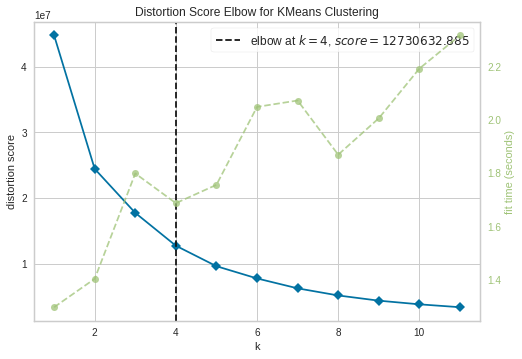

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [101]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(frame)
visualizer.show()

In [102]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(frame)

In [103]:
print(kmeans.labels_)
print(kmeans.inertia_)
print(kmeans.n_iter_)
print(kmeans.cluster_centers_)

[0 0 0 ... 0 0 0]
12730633.270213097
12
[[  1.14542313   2.05996933]
 [ 80.801727     2.925274  ]
 [ 18.04854369 258.90291262]
 [ 24.74977857   6.18024801]]


k-means clustering has four clusters of size 179995, 13545, 3011, and 103, which in our case menas that there's 179995 active performance, 13545 mild performace, and 3011 poor performance...

In [105]:
from collections import Counter
Counter(kmeans.labels_)

Counter({0: 179995, 3: 13545, 1: 3011, 2: 103})

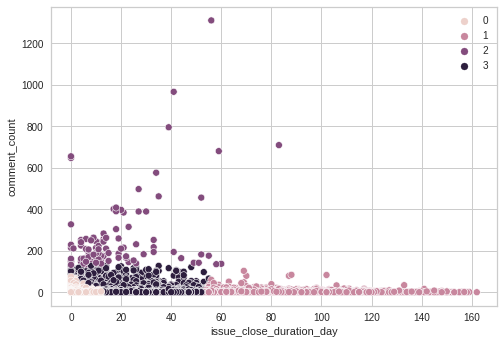

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=frame, x="issue_close_duration_day", y="comment_count", hue=kmeans.labels_)
plt.show()

Question: I used commnet count as y axis, but not sure if that make sense at all

## Activity plot (WIP)

In [162]:
dft = dframe[['rg_name', 'last_updated', 'percentage']].copy()
dft.head()
dft['perc_'] = dft.apply(lambda row : row[2]*100, axis=1)
dft

rg_name         last_updated  percentage       perc_
0    Default Repo Group  2021-10-12 09:19:15    0.000000    0.000000
1    Default Repo Group  2021-10-12 09:19:15    0.000000    0.000000
2    Default Repo Group  2021-10-26 18:15:41   -0.469453  -46.945338
3    Default Repo Group  2021-10-26 18:15:41    0.000000    0.000000
4    Default Repo Group  2021-10-26 18:15:41    0.530547   53.054662
..                  ...                  ...         ...         ...
995              CentOS  2021-05-20 06:55:36    0.000000    0.000000
996              CentOS  2021-05-20 06:55:36    0.000000    0.000000
997              CentOS  2021-05-20 06:55:36    0.000000    0.000000
998              CentOS  2021-05-20 06:55:36    1.000000  100.000000
999              CentOS  2019-07-04 15:28:45    0.000000    0.000000

[1000 rows x 4 columns]

In [157]:
# Plot...
import numpy as np
import matplotlib.pyplot as plt
import july
from july.utils import date_range

dates = date_range('2021-10-12', '2022-07-01')
data = dft['perc_'].to_numpy()

<AxesSubplot:title={'center':'Github Activity'}>

/home/yunlee/.local/lib/python3.10/site-packages/matplotlib/colors.py:1253: RuntimeWarning:

invalid value encountered in subtract

/home/yunlee/.local/lib/python3.10/site-packages/matplotlib/colors.py:1254: RuntimeWarning:

invalid value encountered in true_divide



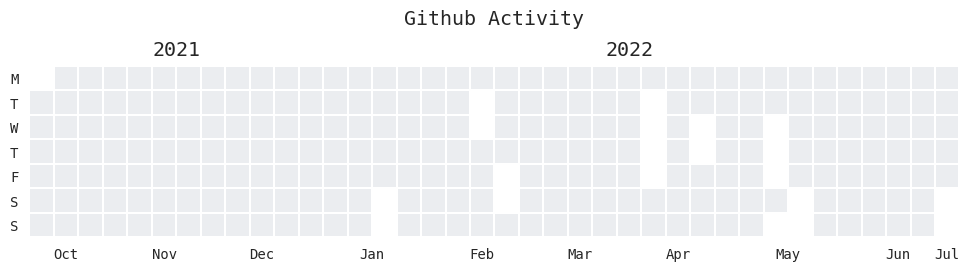

In [159]:
# GitHub Activity like plot (for someone with consistently random work patterns).
july.heatmap(dates, data, title='Github Activity', cmap="github")